<a href="https://colab.research.google.com/github/murthylab/sleap/blob/main/docs/notebooks/Data_structures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data structures

In this notebook, we will explore some of the major data structures used in SLEAP and how they can be manipulated when generating predictions from trained models.

A quick overview of the data structures before we start:

- `Point`/`PredictedPoint` → Contains the `x` and `y` coordinates (and `score` for predictions) of a landmark.
- `Instance`/`PredictedInstance` → Contains a set of `Point`/`PredictedPoint`s. This represent a single individual within a frame and may also contain an associated `Track`.
- `Skeleton` → Defines the nodes and edges that define the set of unique landmark types that each point represents, e.g., "head", "tail", etc. This *does not contain positions* -- those are stored in individual `Point`s.
- `LabeledFrame` → Contains a set of `Instance`/`PredictedInstance`s for a single frame.
- `Labels` → Contains a set of `LabeledFrame`s and the associated metadata for the videos and other information related to the project or predictions.

## 1. Setup SLEAP and data

We'll start by installing SLEAP and downloading some data and models to play around with.

If you get a dependency error in subsequent cells, just click **Runtime** → **Restart runtime** to reload the packages.

In [1]:
# This should take care of all the dependencies on colab:
!pip uninstall -y opencv-python opencv-contrib-python && pip install sleap

# But to do it locally, we'd recommend the conda package (available on Windows + Linux):
# conda create -n sleap -c sleap -c conda-forge -c nvidia sleap

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
Found existing installation: opencv-contrib-python 4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Successfully uninstalled opencv-contrib-python-4.1.2.30
     |████████████████████████████████| 62.0 MB 1.1 MB/s 
     |████████████████████████████████| 1.6 MB 28.0 MB/s 
     |████████████████████████████████| 47.7 MB 82 kB/s 
     |████████████████████████████████| 228 kB 61.2 MB/s 
     |████████████████████████████████| 53 kB 2.3 MB/s 
     |████████████████████████████████| 904 kB 47.6 MB/s 
     |████████████████████████████████| 2.3 MB 51.0 MB/s 
     |████████████████████████████████| 214 kB 63.7 MB/s 
     |████████████████████████████████| 165.5 MB 79 kB/s 
     |████████████████████████████████| 948 kB 54.8 MB/s 
     |████████████████████████████████| 60.5 MB 1.3 MB/s 
     |████████████████████████████████| 51 kB 8.0 MB/s 
     |█

In [2]:
# Test video:
!wget https://storage.googleapis.com/sleap-data/reference/flies13/190719_090330_wt_18159206_rig1.2%4015000-17560.mp4

# Test video labels (from predictions/not necessary for inference benchmarking):
!wget https://storage.googleapis.com/sleap-data/reference/flies13/190719_090330_wt_18159206_rig1.2%4015000-17560.slp

# Bottom-up model:
# !wget https://storage.googleapis.com/sleap-data/reference/flies13/bu.210506_230852.multi_instance.n%3D1800.zip

# Top-down model (two-stage):
!wget https://storage.googleapis.com/sleap-data/reference/flies13/centroid.fast.210504_182918.centroid.n%3D1800.zip
!wget https://storage.googleapis.com/sleap-data/reference/flies13/td_fast.210505_012601.centered_instance.n%3D1800.zip

--2022-04-04 00:19:01--  https://storage.googleapis.com/sleap-data/reference/flies13/190719_090330_wt_18159206_rig1.2%4015000-17560.mp4
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.97.128, 142.251.107.128, 173.194.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85343812 (81M) [video/mp4]
Saving to: ‘190719_090330_wt_18159206_rig1.2@15000-17560.mp4’

190719_090330_wt_18 100%[===================>]  81.39M   142MB/s    in 0.6s    

2022-04-04 00:19:02 (142 MB/s) - ‘190719_090330_wt_18159206_rig1.2@15000-17560.mp4’ saved [85343812/85343812]

--2022-04-04 00:19:02--  https://storage.googleapis.com/sleap-data/reference/flies13/190719_090330_wt_18159206_rig1.2%4015000-17560.slp
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.215.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|17

In [3]:
!ls -lah

total 119M
drwxr-xr-x 1 root root 4.0K Apr  4 00:19  .
drwxr-xr-x 1 root root 4.0K Apr  4 00:15  ..
-rw-r--r-- 1 root root  82M May 20  2021  190719_090330_wt_18159206_rig1.2@15000-17560.mp4
-rw-r--r-- 1 root root 1.6M May 20  2021  190719_090330_wt_18159206_rig1.2@15000-17560.slp
-rw-r--r-- 1 root root 6.1M May 20  2021 'centroid.fast.210504_182918.centroid.n=1800.zip'
drwxr-xr-x 4 root root 4.0K Mar 23 14:21  .config
drwxr-xr-x 1 root root 4.0K Mar 23 14:22  sample_data
-rw-r--r-- 1 root root  30M May 20  2021 'td_fast.210505_012601.centered_instance.n=1800.zip'


In [4]:
import sleap

# This prevents TensorFlow from allocating all the GPU memory, which leads to issues on
# some GPUs/platforms:
sleap.disable_preallocation()

# This would hide GPUs from the TensorFlow altogether:
# sleap.use_cpu_only()

# Print some info:
sleap.versions()
sleap.system_summary()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
SLEAP: 1.2.2
TensorFlow: 2.8.0
Numpy: 1.21.5
Python: 3.7.13
OS: Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic
GPUs: 1/1 available
  Device: /physical_device:GPU:0
         Available: True
        Initalized: False
     Memory growth: True


## 2. Data structures and inference

SLEAP can read videos in a variety of different formats through the `sleap.load_video` high level API. Once loaded, the `sleap.Video` object allows you to access individual frames as if the it were a standard numpy array.

**Note:** The actual frames are not loaded until you access them so we don't blow up our memory when using long videos.

In [5]:
# Videos can be represented agnostic to the backend format
video = sleap.load_video("190719_090330_wt_18159206_rig1.2@15000-17560.mp4")

# sleap.Video objects have a numpy-like interface:
print(video.shape)

# And we can load images in the video using array indexing:
imgs = video[:4]
print(imgs.shape, imgs.dtype)

(2560, 1024, 1024, 1)
(4, 1024, 1024, 1) uint8


The high level interface for loading models (`sleap.load_model()`) takes model folders or zipped folders as input. These are outputs from our training procedure and need to contain a `"best_model.h5"` and `"training_config.json"`.
 
`best_model.h5` is an HDF5-serialized tf.keras.Model that was checkpointed during
training. It includes the architecture as well as the weights, so they're standalone
and don't need SLEAP -- BUT they do not contain the inference methods.

`training_config.json` is a serialized `sleap.TrainingJobConfig` that contains metadata
like what channels of the model correspond to what landmarks and etc.

Top-down models have two stages: centroid and centered instance confidence maps, which we train and save out separately, so loading them together links them up into a single inference model.

In [6]:
# Top-down
predictor = sleap.load_model([
    "centroid.fast.210504_182918.centroid.n=1800.zip",
    "td_fast.210505_012601.centered_instance.n=1800.zip"
    ])

# Bottom-up
# predictor = sleap.load_model("bu.210506_230852.multi_instance.n=1800.zip")

The high level predictor creates all the SLEAP data structures after doing inference. For example:

In [7]:
labels = predictor.predict(video)
labels

Output()

Labels(labeled_frames=2560, videos=1, skeletons=1, tracks=0)

Labels contain not just the predicted data, but all the other associated data structures and metadata:

In [8]:
labels.videos

[Video(backend=MediaVideo(filename='190719_090330_wt_18159206_rig1.2@15000-17560.mp4', grayscale=True, bgr=True, dataset='', input_format='channels_last'))]

In [9]:
labels.skeletons

[Skeleton(name='Skeleton-0', nodes=['head', 'thorax', 'abdomen', 'wingL', 'wingR', 'forelegL4', 'forelegR4', 'midlegL4', 'midlegR4', 'hindlegL4', 'hindlegR4', 'eyeL', 'eyeR'], edges=[('thorax', 'head'), ('thorax', 'abdomen'), ('thorax', 'wingL'), ('thorax', 'wingR'), ('thorax', 'forelegL4'), ('thorax', 'forelegR4'), ('thorax', 'midlegL4'), ('thorax', 'midlegR4'), ('thorax', 'hindlegL4'), ('thorax', 'hindlegR4'), ('head', 'eyeL'), ('head', 'eyeR')], symmetries=[('wingL', 'wingR'), ('forelegL4', 'forelegR4'), ('hindlegL4', 'hindlegR4'), ('eyeL', 'eyeR'), ('midlegL4', 'midlegR4')])]

Individual labeled frames are accessible through a list-like interface:

In [10]:
labeled_frame = labels[0]  # shortcut for labels.labeled_frames[0]
labeled_frame

LabeledFrame(video=MediaVideo('190719_090330_wt_18159206_rig1.2@15000-17560.mp4'), frame_idx=0, instances=2)

Convenient methods allow for easy inspection:

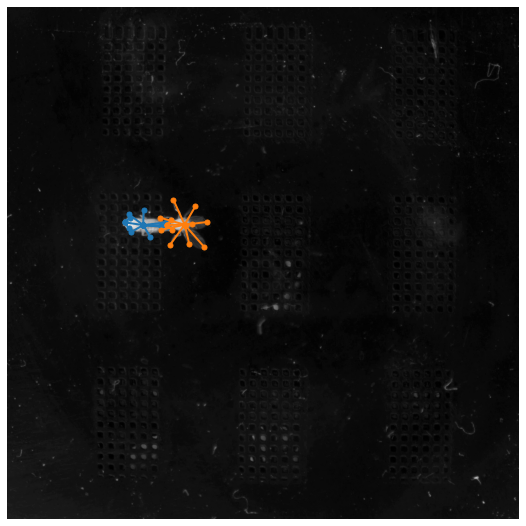

In [11]:
labels[0].plot(scale=0.5)

The labeled frame is itself a container for instances:

In [12]:
labeled_frame.instances

[PredictedInstance(video=Video(filename=190719_090330_wt_18159206_rig1.2@15000-17560.mp4, shape=(2560, 1024, 1024, 1), backend=MediaVideo), frame_idx=0, points=[head: (234.2, 430.5, 0.98), thorax: (271.6, 436.1, 0.94), abdomen: (308.0, 438.6, 0.59), wingL: (321.8, 440.1, 0.39), wingR: (322.0, 436.8, 0.49), forelegL4: (246.1, 450.6, 0.92), forelegR4: (242.3, 413.9, 0.78), midlegL4: (285.8, 459.9, 0.47), midlegR4: (272.3, 406.7, 0.77), hindlegR4: (317.6, 430.6, 0.30), eyeL: (242.1, 441.9, 0.89), eyeR: (245.3, 420.9, 0.92)], score=0.95, track=None, tracking_score=0.00),
 PredictedInstance(video=Video(filename=190719_090330_wt_18159206_rig1.2@15000-17560.mp4, shape=(2560, 1024, 1024, 1), backend=MediaVideo), frame_idx=0, points=[head: (319.4, 435.9, 0.83), thorax: (354.4, 435.2, 0.80), abdomen: (368.3, 433.8, 0.71), wingL: (393.9, 480.3, 0.83), wingR: (398.4, 430.0, 0.81), forelegL4: (307.8, 445.7, 0.26), forelegR4: (305.6, 421.4, 0.69), midlegL4: (325.7, 475.0, 0.94), midlegR4: (331.8, 38

In [13]:
instance = labeled_frame[0]  # shortcut for labeled_frame.instances[0]
instance

PredictedInstance(video=Video(filename=190719_090330_wt_18159206_rig1.2@15000-17560.mp4, shape=(2560, 1024, 1024, 1), backend=MediaVideo), frame_idx=0, points=[head: (234.2, 430.5, 0.98), thorax: (271.6, 436.1, 0.94), abdomen: (308.0, 438.6, 0.59), wingL: (321.8, 440.1, 0.39), wingR: (322.0, 436.8, 0.49), forelegL4: (246.1, 450.6, 0.92), forelegR4: (242.3, 413.9, 0.78), midlegL4: (285.8, 459.9, 0.47), midlegR4: (272.3, 406.7, 0.77), hindlegR4: (317.6, 430.6, 0.30), eyeL: (242.1, 441.9, 0.89), eyeR: (245.3, 420.9, 0.92)], score=0.95, track=None, tracking_score=0.00)

Finally, instances are containers for points:

In [14]:
instance.points

(PredictedPoint(x=234.244384765625, y=430.52001953125, visible=True, complete=False, score=0.9790461659431458),
 PredictedPoint(x=271.5894470214844, y=436.1461181640625, visible=True, complete=False, score=0.9357967376708984),
 PredictedPoint(x=308.02899169921875, y=438.5711975097656, visible=True, complete=False, score=0.5859644412994385),
 PredictedPoint(x=321.8167419433594, y=440.0872802734375, visible=True, complete=False, score=0.3912011682987213),
 PredictedPoint(x=322.0196533203125, y=436.77008056640625, visible=True, complete=False, score=0.48613619804382324),
 PredictedPoint(x=246.1430206298828, y=450.56182861328125, visible=True, complete=False, score=0.9176540970802307),
 PredictedPoint(x=242.2632293701172, y=413.94976806640625, visible=True, complete=False, score=0.7807964086532593),
 PredictedPoint(x=285.78167724609375, y=459.9156494140625, visible=True, complete=False, score=0.4739593267440796),
 PredictedPoint(x=272.27996826171875, y=406.71759033203125, visible=True, com

These can be converted into concrete arrays:

In [15]:
pts = instance.numpy()
print(pts)

[[234.24438477 430.52001953]
 [271.58944702 436.14611816]
 [308.0289917  438.57119751]
 [321.81674194 440.08728027]
 [322.01965332 436.77008057]
 [246.14302063 450.56182861]
 [242.26322937 413.94976807]
 [285.78167725 459.91564941]
 [272.27996826 406.71759033]
 [         nan          nan]
 [317.59976196 430.60525513]
 [242.10380554 441.94561768]
 [245.32002258 420.93609619]]


Images can be embedded together with the predictions in the same format:

In [16]:
labels = sleap.Labels(labels.labeled_frames[:4])  # crop to the first few labels for this example
labels.save("labels_with_images.pkg.slp", with_images=True, embed_all_labeled=True)

Let's delete the source data:

In [17]:
!rm "190719_090330_wt_18159206_rig1.2@15000-17560.mp4"

And check out what happens when we load in some labels with embedded images:

In [18]:
labels = sleap.load_file("labels_with_images.pkg.slp")
labels

Labels(labeled_frames=4, videos=1, skeletons=1, tracks=0)

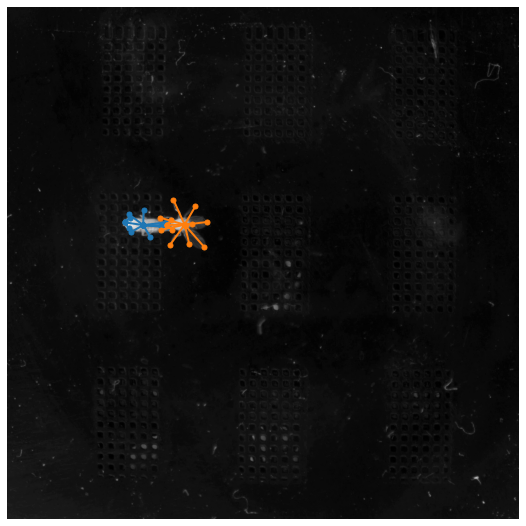

In [19]:
labels[0].plot(scale=0.5)